In [1]:
import networkx as nx
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import Aer
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram

import numpy as np
from scipy.optimize import minimize

In [2]:
# dij需求i到设施j的成本
d = [[1, 2], [1, 2]]
n = 2   # 两个设施点
m = 2   # 两个需求点
# d = [[1, 2], [3, 4], [5, 6]]
# n = 2   # 两个设施点
# m = 3   # 三个需求点
num_qubits = n +  n * m

# gi设施i的建设成本
g = [2, 1]


In [3]:
penalty = 25
depth = 3
params = np.ones(depth * 2)

In [4]:
# dtype=np.complex128
def add_in_target(num_qubits, target_qubit, gate=np.array([[1, 0],[0, -1]])):
    H = np.eye(2 ** (target_qubit))
    H = np.kron(H, gate)
    H = np.kron(H, np.eye(2 ** (num_qubits - 1 - target_qubit)))
    return H


def generate_Hp(n, m, d, g):
    # 初始化 Hp 矩阵为零矩阵
    # print(num_qubits)
    Hp = np.zeros((2**num_qubits, 2**num_qubits))
    for i in range(m):
        for j in range(n):
            Hp += d[i][j] * (add_in_target(num_qubits, n * (1 + i) + j) - np.eye(2**num_qubits)) / 2
    
    for j in range(n):
        Hp +=  g[j] * (add_in_target(num_qubits, j)- np.eye(2**num_qubits)) / 2

    return Hp

In [5]:
GateX = np.array([[0, 1],[1, 0]])
GateY = np.array([[0, -1j],[1j, 0]])
GateZ = np.array([[1, 0],[0, -1]])

def add_in_target(num_qubits, target_qubit, gate=np.array([[1, 0],[0, -1]])):
    H = np.eye(2 ** (target_qubit))
    H = np.kron(H, gate)
    H = np.kron(H, np.eye(2 ** (num_qubits - 1 - target_qubit)))
    return H
def generate_H():
    Hp = np.zeros((2**6, 2**6))
    for i in range(6):
        Hp +=  add_in_target(6, i, GateX)
    return Hp
# 求解本征值和本征态
eigenvalues, eigenvectors = np.linalg.eig(generate_H())
print(eigenvalues)
# 输出结果
for i in range(len(eigenvalues)):
  print("\nEigenvalues:")
  print(f'{eigenvalues[i].real:.4f}')
  print("Eigenvectors:")
  print([f'{num:.4f}' for num in eigenvectors[:, i].real])

[ 6.00000000e+00+0.00000000e+00j -6.00000000e+00+0.00000000e+00j
  6.87168415e-16+0.00000000e+00j -4.00000000e+00+0.00000000e+00j
 -4.00000000e+00+0.00000000e+00j  4.94951116e-17+6.15503286e-17j
  4.94951116e-17-6.15503286e-17j -4.00000000e+00+0.00000000e+00j
 -4.00000000e+00+0.00000000e+00j -4.00000000e+00+0.00000000e+00j
  1.39113699e-16+0.00000000e+00j -5.34099882e-17+0.00000000e+00j
  4.00000000e+00+0.00000000e+00j  4.00000000e+00+0.00000000e+00j
  4.00000000e+00+0.00000000e+00j  4.00000000e+00+0.00000000e+00j
  4.00000000e+00+0.00000000e+00j  4.00000000e+00+0.00000000e+00j
 -4.00000000e+00+0.00000000e+00j -3.90721912e-17+0.00000000e+00j
 -2.00000000e+00+0.00000000e+00j -2.00000000e+00+0.00000000e+00j
 -2.00000000e+00+0.00000000e+00j -2.00000000e+00+0.00000000e+00j
 -2.00000000e+00+0.00000000e+00j  1.67369090e-16+0.00000000e+00j
 -3.01587058e-17+0.00000000e+00j -2.00000000e+00+0.00000000e+00j
 -2.00000000e+00+0.00000000e+00j  3.91376126e-16+0.00000000e+00j
 -1.76087929e-16+0.000000

In [6]:
from scipy.linalg import expm
def build_circ(n, m, d, g, params):
  qc = QuantumCircuit(num_qubits)
  beta = params[:depth + 1]
  gamma = params[depth:]
  # for i in range(num_qubits):
  #   qc.h(i)
  #   qc.z(i)
  qc.initialize(eigenvectors[:, 1].real, range(6))
  for dp in range(depth):
    qc.unitary(expm(-1j * gamma[dp] * generate_Hp(n, m, d, g)), range(num_qubits))
    for i in range(num_qubits):
      qc.rx(beta[dp], i)
  qc.measure_all()
  return qc

In [7]:
def cost_function(x):
  num = [int(char) for char in x]
  C = 0
  for i in range(m):
    for j in range(n):
      C += d[i][j] * num[n * (1 + i) + j]
      
  for j in range(n):
    C += g[j] * num[j]

  return C

def compute_expectation(counts):
  EV = 0
  total_count = 0
  for x, count in counts.items():
    C = cost_function(x)
    EV += C*count
    total_count += count

  return EV/total_count


def expectation_from_sample(shots = 2000):
  backend = Aer.get_backend('qasm_simulator')
  backend.shots = shots

  def execute_circ(theta):
    qc = build_circ(n, m, d, g, theta)
    counts = backend.run(qc, seed_simulator=10, shots=shots).result().get_counts()
    return compute_expectation(counts)
  
  return execute_circ

In [8]:
from scipy.optimize import minimize
import numpy as np

expectation = expectation_from_sample()

def callback(x):
    global iteration_count
    iteration_count += 1
    if iteration_count % 10 == 0:
        print(f"Iteration {iteration_count}, Result: {expectation(x)}")

# 设定最大迭代次数
max_iterations = 1000

# 初始化迭代计数器
iteration_count = 0

# 使用 COBYLA 方法进行最小化，并设置 callback 函数
res = minimize(expectation, params, method='COBYLA', options={'maxiter': max_iterations}, callback=callback)

# 输出最终结果
print("Final Result:", res)

Iteration 10, Result: 1.5005
Iteration 20, Result: 0.453
Iteration 30, Result: 0.429
Iteration 40, Result: 0.404
Iteration 50, Result: 0.4025
Iteration 60, Result: 0.402
Final Result:  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.401
       x: [ 1.321e+00  2.945e+00  4.838e-01  8.220e-01  2.425e-01
            1.943e-02]
    nfev: 67
   maxcv: 0.0


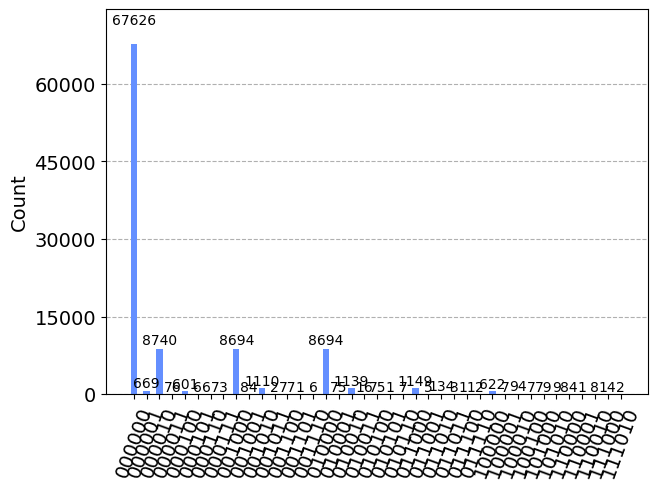

In [9]:
from numpy.lib.utils import source
backend = Aer.get_backend('aer_simulator')
backend.shots = 100000

shots=100000
qc_res = build_circ(n, m, d, g, params=res.x)

counts = backend.run(qc_res, seed_simulator=10, shots = shots).result().get_counts()
plot_histogram(counts)

In [10]:
qc_res.draw()

»
   q_0: »
        »
   q_1: »
        »
   q_2: »
        »
   q_3: »
        »
   q_4: »
        »
   q_5: »
        »
meas: 6/»
        »
«        ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«   q_0: ┤0                                                                                                                                                                                                                                                                                                                                                                                                                                             ├»
«        │                                                                                                                                                                                                                                                                                                                                                                                                                                              │»
«   q_1: ┤1                                                                                                                                                                                                                                                                                                                                                                                                                                             ├»
«        │                                                                                                                                                                                                                                                                                                                                                                                                                                              │»
«   q_2: ┤2                                                                                                                                                                                                                                                                                                                                                                                                                                             ├»
«        │  Initialize(-0.125,0.125,0.125,-0.125,0.125,-0.125,-0.125,0.125,0.125,-0.125,-0.125,0.125,-0.125,0.125,0.125,-0.125,0.125,-0.125,-0.125,0.125,-0.125,0.125,0.125,-0.125,-0.125,0.125,0.125,-0.125,0.125,-0.125,-0.125,0.125,0.125,-0.125,-0.125,0.125,-0.125,0.125,0.125,-0.125,-0.125,0.125,0.125,-0.125,0.125,-0.125,-0.125,0.125,-0.125,0.125,0.125,-0.125,0.125,-0.125,-0.125,0.125,0.125,-0.125,-0.125,0.125,-0.125,0.125,0.125,-0.125) │»
«   q_3: ┤3                                                                                                                                                                                                                                                                                                                                                                                                                                             ├»
«        │                                                                                                                                                                                                                                                                                                                

In [11]:
sorted_counts = sorted(counts, key=counts.get, reverse=True)
print("\n----------------- Full result ---------------------")
print("selection\t\tprobability\tvalue")
print("---------------------------------------------------")
for x in sorted_counts[:20]:
  print(x, "{:.1f}%".format(counts[x] / shots * 100), cost_function(x))


----------------- Full result ---------------------
selection		probability	value
---------------------------------------------------
000000 67.6% 0
000010 8.7% 1
010000 8.7% 1
001000 8.7% 1
011000 1.1% 2
010010 1.1% 2
001010 1.1% 2
000001 0.7% 2
100000 0.6% 2
000100 0.6% 2
011010 0.1% 3
100010 0.1% 3
001001 0.1% 3
110000 0.1% 3
101000 0.1% 3
001100 0.1% 3
000011 0.1% 3
010100 0.1% 3
010001 0.1% 3
000110 0.1% 3
